In [1]:
import sys

sys.path.append("../../")
sys.path.append("../")

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import torch
#sys.path.append('/home/exx/git/Tangram/')  # uncomment for local import
import tangram2_coeff as tg
from scipy.io import mmread
import utils
import scipy as sci


%load_ext autoreload
%autoreload 2
%matplotlib inline

tg.__version__

'1.0.0'

In [3]:
ad_sc = sc.read_h5ad('/gstore/data/resbioai/tangram2_data/breast_cancer/single_cell/Wu_etal_2021_BRCA_scRNASeq/ad_sc.h5ad')

In [5]:
patient_ID = ['CID4290', 'CID4535', 'CID4465', 'CID44971']

In [7]:
ad_sp = sc.read_h5ad('/gstore/data/resbioai/tangram2_data/breast_cancer/spatial/ad_sp_' + patient_ID[2] + '.h5ad')
ad_sp.obs['subtype'].values[0]

'TNBC'

In [9]:
markers = list(pd.read_csv('../additional_analysis/marker/marker_genes_paper.txt', index_col=0).index)

In [10]:
ad_map_all = []
for i in range(3,4):#len(patient_ID)):
    ad_sp = sc.read_h5ad('/gstore/data/resbioai/tangram2_data/breast_cancer/spatial/ad_sp_' + patient_ID[i] + '.h5ad')

    if ad_sp.obs['subtype'].values[0] == 'ER':
        ad_sc_mapping  = ad_sc[ad_sc.obs['subtype'] == 'ER+']
        print('cancer subtype: ' + ad_sp.obs['subtype'].values[0])
    elif ad_sp.obs['subtype'].values[0] == 'TNBC':
        ad_sc_mapping  = ad_sc[ad_sc.obs['subtype'] == 'TNBC']
        print('cancer subtype: ' + ad_sp.obs['subtype'].values[0])
        
    #if patient_ID[i] == 'CID44971':
    #    ad_sp = ad_sp[~((ad_sp.obs['x']<72)*(ad_sp.obs['y']<20))]
    
    ad_sc_subtype = sc.AnnData(
                X=np.zeros((len(ad_sc_mapping.obs['celltype_subset'].unique()),ad_sc_mapping.shape[1])),
                var=ad_sc_mapping.var.copy(),
            )
    ad_sc_subtype.obs.index = ad_sc_mapping.obs['celltype_subset'].unique()

    minor_type = []
    major_type = []

    for j in ad_sc_subtype.obs.index:
        ad_sc_subtype[ad_sc_subtype.obs.index == j] = ad_sc_mapping[ad_sc_mapping.obs['celltype_subset'] == j].X.mean(axis = 0)
        minor_type.append(ad_sc_mapping[ad_sc_mapping.obs['celltype_subset'] == j].obs['celltype_minor'].values[0])
        major_type.append(ad_sc_mapping[ad_sc_mapping.obs['celltype_subset'] == j].obs['celltype_major'].values[0])
    
    ad_sc_subtype.obs['celltype_subset'] = ad_sc_subtype.obs.index
    ad_sc_subtype.obs['celltype_minor'] = minor_type
    ad_sc_subtype.obs['celltype_major'] = major_type

    tg.pp_adatas(ad_sc_subtype, ad_sp, genes=markers)
    
    ad_map = tg.map_cells_to_space(ad_sc_subtype, ad_sp,
        mode="cells",
        #     mode="clusters",
        #     cluster_label='cell_subclass',  # .obs field w cell types
        #density_prior='rna_count_based',
        #num_epochs=500,
        # device="cuda:0",
        device='cuda:0',
        #cluster_label = 'fine.class'
    )

    ad_map.X = ad_map.X*ad_map.obs['coefficient'][:, None]
    
    ad_map_all.append(ad_map)

    #tg.project_cell_annotations(ad_map, ad_sp, annotation='celltype_subset')
    #annotation_list = list(pd.unique(ad_sc_mapping.obs['celltype_subset']))
    #tg.plot_cell_annotation_sc(ad_sp, annotation_list, perc=0.001)

    #plt.savefig('celltype_subset/'+ patient_ID[i]  + '.png')#, dpi=300)

    #tg.project_cell_annotations(ad_map, ad_sp, annotation='celltype_minor')
    #annotation_list = list(pd.unique(ad_sc_mapping.obs['celltype_minor']))
    #tg.plot_cell_annotation_sc(ad_sp, annotation_list, perc=0.001)

    #plt.savefig('celltype_minor/'+ patient_ID[i]  + '.png')#, dpi=300)

    #tg.project_cell_annotations(ad_map, ad_sp, annotation='celltype_major')
    #annotation_list = list(pd.unique(ad_sc_mapping.obs['celltype_major']))
    #tg.plot_cell_annotation_sc(ad_sp, annotation_list, perc=0.001)

    #plt.savefig('celltype_major/'+ patient_ID[i]  + '.png')#, dpi=300)

cancer subtype: TNBC


INFO:root:3462 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
INFO:root:16081 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
INFO:root:uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
INFO:root:rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.
INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 3462 genes and rna_count_based density_prior in cells mode...
INFO:root:Printing scores every 100 epochs.


Score: 0.717, VG reg: 0.717, KL reg: 4.165
Score: 0.791, VG reg: 0.791, KL reg: 3.892
Score: 0.792, VG reg: 0.792, KL reg: 3.892
Score: 0.792, VG reg: 0.792, KL reg: 3.892
Score: 0.792, VG reg: 0.792, KL reg: 3.892
Score: 0.792, VG reg: 0.792, KL reg: 3.892
Score: 0.792, VG reg: 0.792, KL reg: 3.892
Score: 0.792, VG reg: 0.792, KL reg: 3.892
Score: 0.793, VG reg: 0.793, KL reg: 3.892
Score: 0.793, VG reg: 0.793, KL reg: 3.892


INFO:root:Saving results..


INFO:root:spatial prediction dataframe is saved in `obsm` `tangram_ct_pred` of the spatial AnnData.


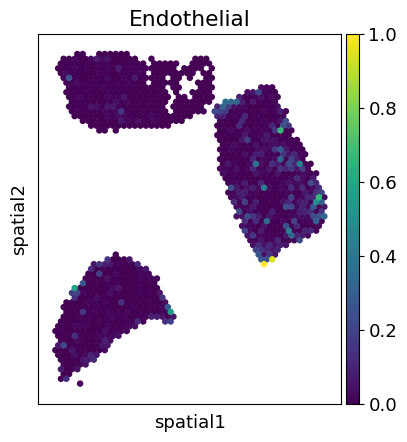

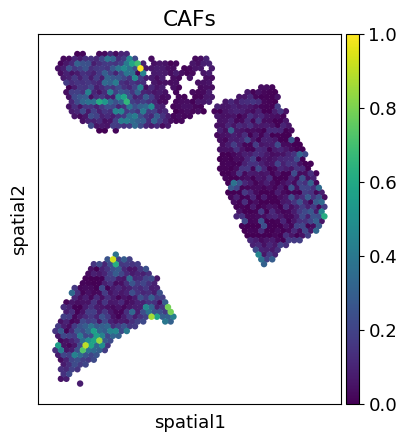

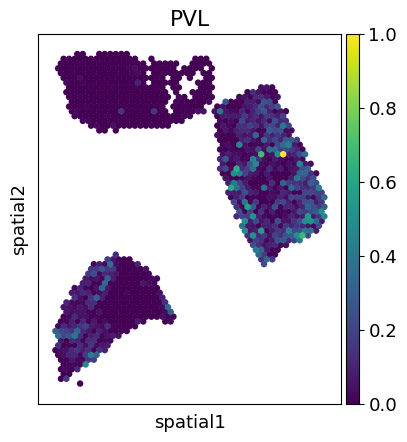

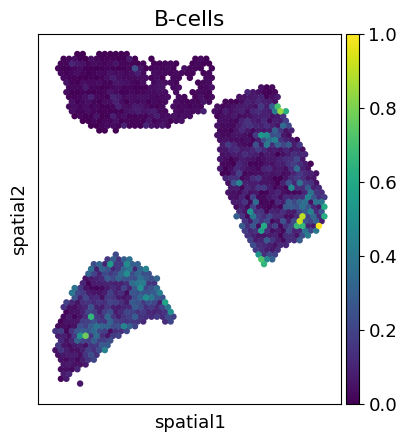

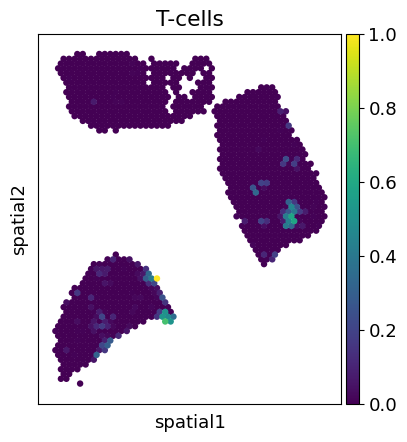

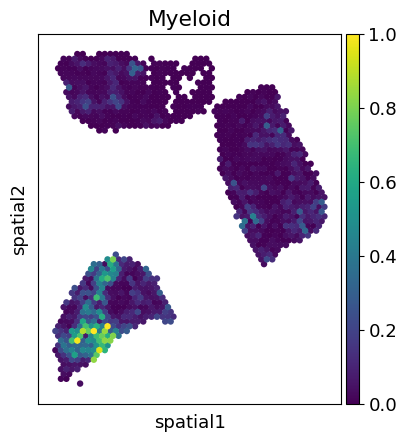

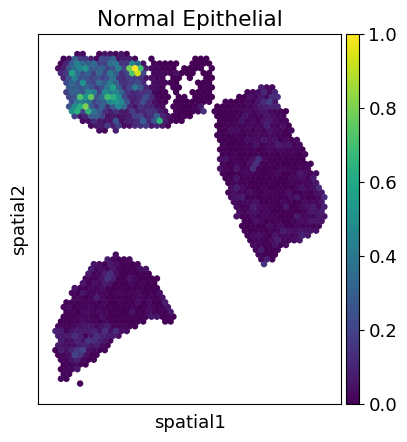

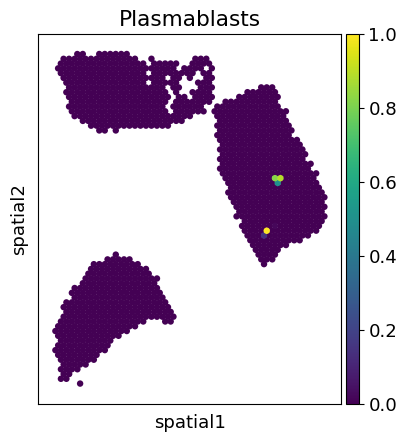

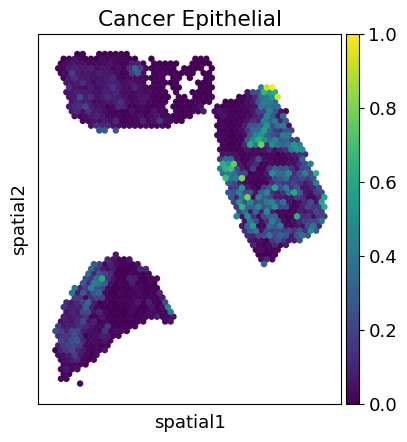

In [13]:
tg.project_cell_annotations(ad_map, ad_sp, annotation='celltype_major')
annotation_list = list(pd.unique(ad_sc_mapping.obs['celltype_major']))

#import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 13})

for i in annotation_list:
    
    list_i = [i]
    #tg.plot_cell_annotation_sc(ad_sp, [i], perc=0.001)
    ad_sp.obs.drop(list_i, inplace=True, errors="ignore", axis=1)

    # construct df_plot
    df = ad_sp.obsm["tangram_ct_pred"][list_i]
    tg.construct_obs_plot(df, ad_sp, perc=0)

    sc.pl.spatial(
        ad_sp, color=list_i, cmap="viridis", show=False,  img_key=None, size=1.8
    )    
    #frameon=False,
    ###################plt.savefig('figure3/'+ i  + '.pdf', dpi=300)